In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np


data_dir = 'flowers/'

transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Изменение размера изображений
    transforms.ToTensor(),         # Конвертация в тензор
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(10),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Нормализация
])

dataset = ImageFolder(root=data_dir, transform=transform)

In [5]:
dataset.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [6]:
from torch.utils.data import random_split, DataLoader

train_size = int(0.7 * len(dataset))  # 70% данных для тренировки
val_size = int(0.2 * len(dataset))    # 20% данных для валидации
test_size = len(dataset) - train_size - val_size  # Оставшиеся 10% для теста

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [9]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        # Сверточные слои
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Полносвязные слои
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, num_classes)

        # Dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(-1, 128 * 16 * 16)  
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x) 
        return x

num_classes = 5
model = CNN(num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) 


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_epochs = 10
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(num_epochs):
    # Обучение
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Валидация
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct / total)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%")


Epoch 1/10, Train Loss: 1.4347, Val Loss: 1.2503, Val Accuracy: 46.35%
Epoch 2/10, Train Loss: 1.2541, Val Loss: 1.1885, Val Accuracy: 49.25%
Epoch 3/10, Train Loss: 1.1816, Val Loss: 1.1157, Val Accuracy: 54.58%
Epoch 4/10, Train Loss: 1.1140, Val Loss: 1.0991, Val Accuracy: 57.71%
Epoch 5/10, Train Loss: 1.0289, Val Loss: 1.0619, Val Accuracy: 56.43%
Epoch 6/10, Train Loss: 0.9444, Val Loss: 0.9954, Val Accuracy: 61.07%
Epoch 7/10, Train Loss: 0.8854, Val Loss: 0.9587, Val Accuracy: 63.38%
Epoch 8/10, Train Loss: 0.8290, Val Loss: 0.9587, Val Accuracy: 63.04%
Epoch 9/10, Train Loss: 0.7697, Val Loss: 0.8992, Val Accuracy: 66.40%
Epoch 10/10, Train Loss: 0.7343, Val Loss: 1.0265, Val Accuracy: 60.83%


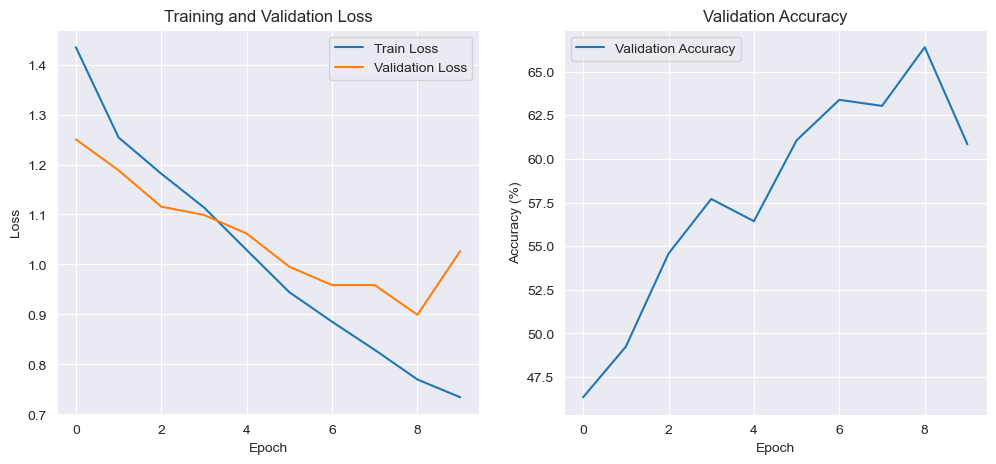

In [11]:
plt.figure(figsize=(12, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy")
plt.legend()

plt.show()

In [12]:
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy:.2f}%")


Test Loss: 1.0106, Test Accuracy: 63.05%


In [15]:
torch.save(model.state_dict(), "flower_cnn.pth")